# Wyoming Inter-County Mobility Network Analysis (2018–2024)

This notebook uses device stop data from Advan Mobility to create mobility networks that show how people move between counties.

For each year and season (e.g., July 2019, December 2022):



- Parse raw stop data: identify where each device stopped within a destination CBG and the corresponding county.

- Group trips by county: specify start and end counties for each movement.

- Separate intra-county and inter-county flows: categorize trips as within the same county or between different counties.

- Construct a directed network graph: represent counties as nodes and movement volumes as weighted edges.

- Restrict analysis to trips starting in Wyoming, where the county code has the prefix 56.

- Calculate basic network metrics: clustering coefficient and degree distribution.

- Generate a network visualization (spring layout) and a degree histogram.
- Repeat these steps for each year from 2018 to 2024, focusing on both July and December.

All figures are both displayed in the notebook and saved to an output folder for further analysis, reporting, and inclusion in reports or papers.

### ***1. Imports and configuration***

In [5]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

#configuration

DATA_DIR = Path(r"F:\Yellow Stone Flood-2022\floodanalysis\Data\Advan Mobility")
OUTPUT_BASE = Path(r"F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks")

SEASONS = ["July", "Dec"]            
YEARS   = list(range(2018, 2025))    

OUTPUT_BASE.mkdir(parents=True, exist_ok=True)

print("Data directory:", DATA_DIR)
print("Output directory:", OUTPUT_BASE)
print("Seasons:", SEASONS)
print("Years:", YEARS)


Data directory: F:\Yellow Stone Flood-2022\floodanalysis\Data\Advan Mobility
Output directory: F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks
Seasons: ['July', 'Dec']
Years: [2018, 2019, 2020, 2021, 2022, 2023, 2024]


### ***2 Define Helper Function: `safe_parse()`***

In [6]:
def safe_parse(x):
    """
    DEVICE_HOME_AREAS is saved as a JSON-style string that links each origin CBG to a device count.
    The function returns a dictionary. If it cannot parse the input, it returns an empty dictionary.
    """
    try:
        return json.loads(x)
    except Exception:
        return {}


### ***3 Build County Flow Function***

In [7]:
def build_county_flows(year, season, data_dir=DATA_DIR):
    """
    For each year and season, first read the mobility file. Next, expand the nested CBG dictionaries. Finally, aggregate the flows from the origin county to the destination county.
    """
    file_name = f"{season}_{year}_Only.csv"
    file_path = data_dir / file_name
    
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"[WARN] Missing file: {file_path}")
        return None, None, None

    # Parse home origins dict
    df["home_dict"] = df["DEVICE_HOME_AREAS"].apply(safe_parse)

    # Explode device origins
    records = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Expanding {file_name}"):
        dest_cbg = str(row["AREA"]).strip()
        for origin_cbg, count in row["home_dict"].items():
            origin_cbg = str(origin_cbg).strip()
            records.append((origin_cbg, dest_cbg, count))

    flows = pd.DataFrame(records, columns=["origin_cbg", "dest_cbg", "count"])

    # extract county FIPS 
    flows["origin_cbg"] = flows["origin_cbg"].astype(str).str.strip()
    flows["dest_cbg"]   = flows["dest_cbg"].astype(str).str.strip()
    flows["origin_cnty"] = flows["origin_cbg"].str[:5]
    flows["dest_cnty"]   = flows["dest_cbg"].str[:5]

    # Aggregate to county-to-county
    agg = (
        flows.groupby(["origin_cnty", "dest_cnty"], as_index=False)["count"]
        .sum()
        .sort_values("count", ascending=False)
    )

    intra = agg[agg["origin_cnty"] == agg["dest_cnty"]].copy()
    inter = agg[agg["origin_cnty"] != agg["dest_cnty"]].copy()

    print(f"[INFO] {file_name} | intra-county links: {len(intra)} | inter-county links: {len(inter)}")
    return agg, intra, inter


### ***4 Build Network Graphs Function***

In [8]:
def build_graphs(inter_df):
    """
   If there is movement between different counties, where the origin county is not the same as the destination county,
    return:
      G_all : DiGraph of all flows
      G_wy  : DiGraph where origin_cnty starts with '56' (Wyoming)
    """
    if inter_df is None or inter_df.empty:
        return None, None

    # directed graph
    G_all = nx.from_pandas_edgelist(
        inter_df,
        source='origin_cnty',
        target='dest_cnty',
        edge_attr='count',
        create_using=nx.DiGraph()
    )

    # WY-only origins
    wyoming_edges = inter_df[
        inter_df["origin_cnty"].str.startswith("56")
    ].copy()

    G_wy = nx.from_pandas_edgelist(
        wyoming_edges,
        source='origin_cnty',
        target='dest_cnty',
        edge_attr='count',
        create_using=nx.DiGraph()
    )

    return G_all, G_wy


### ***5 Plot Wyoming Network Function***


In [9]:
def plot_wy_network(G_wy, inter_df, title=None, show=True, save_path=None):
    """
    Create a directed mobility network for Wyoming and display it with a spring layout.
    Make the edges thicker where the flow count is higher.
    """

    if G_wy is None or G_wy.number_of_nodes() == 0:
        return

    plt.figure(figsize=(10, 8))

    # layout
    pos = nx.spring_layout(G_wy, k=0.8, iterations=50, seed=42)

    # normalize edge width by flow magnitude
    wy_edges = inter_df[inter_df["origin_cnty"].str.startswith("56")]
    max_w = wy_edges["count"].max() if not wy_edges.empty else 1.0

    widths = []
    for u, v, d in G_wy.edges(data=True):
        w = d.get("count", 1)
        widths.append((w / max_w) * 5 if max_w else 1)

    nx.draw(
        G_wy,
        pos,
        node_size=16,
        arrowsize=10,
        edge_color='gray',
        width=widths,
        with_labels=False,
        alpha=0.7
    )

    plt.title(title if title else "Inter-County Mobility Network (WY origins only)")
    plt.axis("off")

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[SAVE] Network plot -> {save_path}")
    if show:
        plt.show()
    else:
        plt.close()


### ***Analyze Wyoming Network Function***


In [10]:
def analyze_graph(G_wy, year, season, show=True, save_dir=None):
    """
     Calculate the main network statistics for the Wyoming mobility network only.
       - average clustering coefficient
       - degree distribution
     Create a histogram as well, and save it if needed.
    """
    if G_wy is None or G_wy.number_of_nodes() == 0:

        return None

    # clustering 
    clustering_coeff = nx.average_clustering(G_wy.to_undirected())
    print(f"[STATS] {season} {year} | Avg clustering coeff: {clustering_coeff:.4f}")

    # degree histogram
    hist_counts = nx.degree_histogram(G_wy)  
    degrees = list(range(len(hist_counts)))

    plt.figure(figsize=(10, 6))
    plt.bar(degrees, hist_counts, width=0.8, color='b')
    plt.title(f"Degree Distribution ({season} {year})")
    plt.xlabel("Degree")
    plt.ylabel("Number of counties")
    plt.grid(axis='y', alpha=0.3)

    if save_dir is not None:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        hist_path = save_dir / f"DegreeDist_{season}_{year}.png"
        plt.savefig(hist_path, dpi=300, bbox_inches="tight")
        print(f"[SAVE] Degree distribution -> {hist_path}")

    if show:
        plt.show()
    else:
        plt.close()

    return {
        "year": year,
        "season": season,
        "avg_clustering": clustering_coeff,
        "degree_histogram": hist_counts,
    }


### ***7 Process Snapshot Function***

In [11]:
def process_snapshot(year, season,
                     data_dir=DATA_DIR,
                     output_base=OUTPUT_BASE,
                     show_plots=True):
    """
        Run the complete workflow for a single snapshot.
        The function returns a dictionary with the following items:
           - aggregated flows
           - intra-county flows
           - inter-county flows
           - graphs
           - stats
    """
    agg_df, intra_df, inter_df = build_county_flows(year, season, data_dir=data_dir)
    if agg_df is None:
        return None

    G_all, G_wy = build_graphs(inter_df)

    # make snapshot-specific output folder
    snap_dir = output_base / f"{year}_{season}"
    snap_dir.mkdir(parents=True, exist_ok=True)

    # plot 
    net_fig_path = snap_dir / f"WY_Network_{season}_{year}.png"
    plot_wy_network(
        G_wy,
        inter_df,
        title=f"Inter-County Mobility Network (WY origins only)\n{season} {year}",
        show=show_plots,
        save_path=net_fig_path
    )

    # plot 
    stats = analyze_graph(
        G_wy,
        year,
        season,
        show=show_plots,
        save_dir=snap_dir
    )

    # package everything
    result = {
        "year": year,
        "season": season,
        "agg_flows": agg_df,
        "intra_flows": intra_df,
        "inter_flows": inter_df,
        "G_all": G_all,
        "G_wy": G_wy,
        "graph_stats": stats,
        "output_folder": snap_dir
    }

    return result


### ***8 Run Full Yearly Processing Loop***


=== Processing July 2018 ===


Expanding July_2018_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 4019.71it/s]


[INFO] July_2018_Only.csv | intra-county links: 23 | inter-county links: 16048
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2018_July\WY_Network_July_2018.png


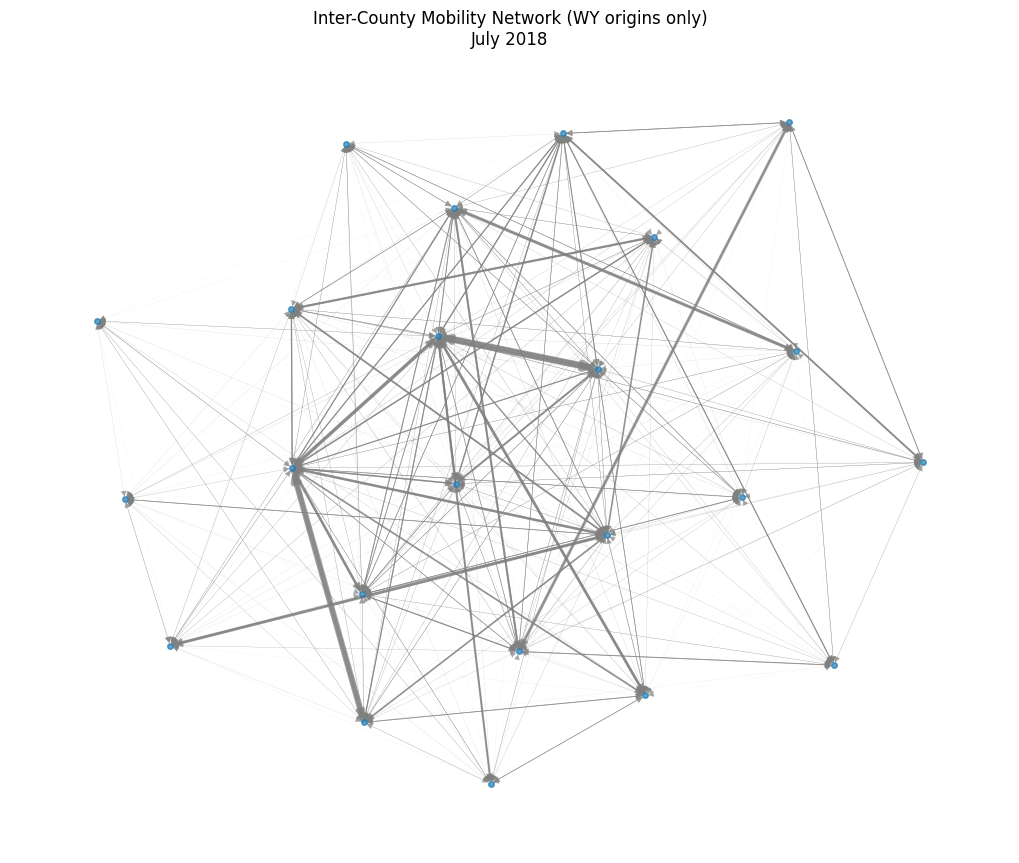

[STATS] July 2018 | Avg clustering coeff: 0.9678
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2018_July\DegreeDist_July_2018.png


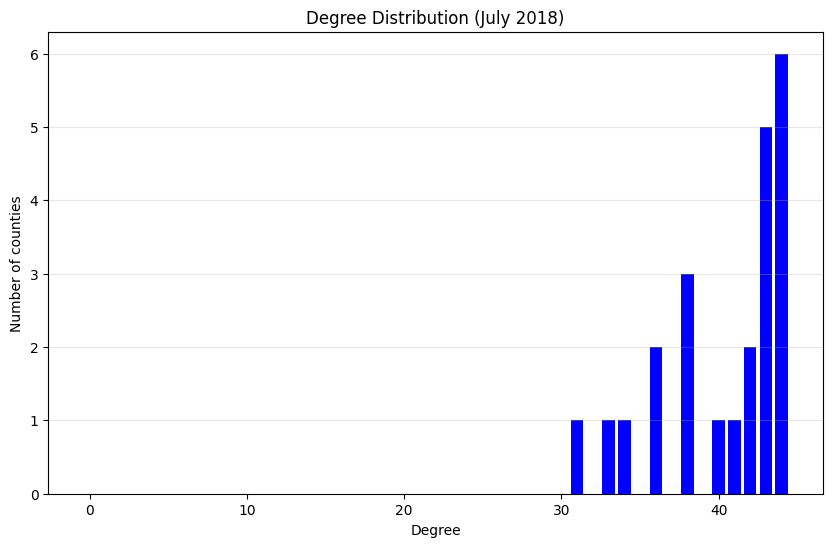


=== Processing Dec 2018 ===


Expanding Dec_2018_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 5286.18it/s]


[INFO] Dec_2018_Only.csv | intra-county links: 23 | inter-county links: 6312
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2018_Dec\WY_Network_Dec_2018.png


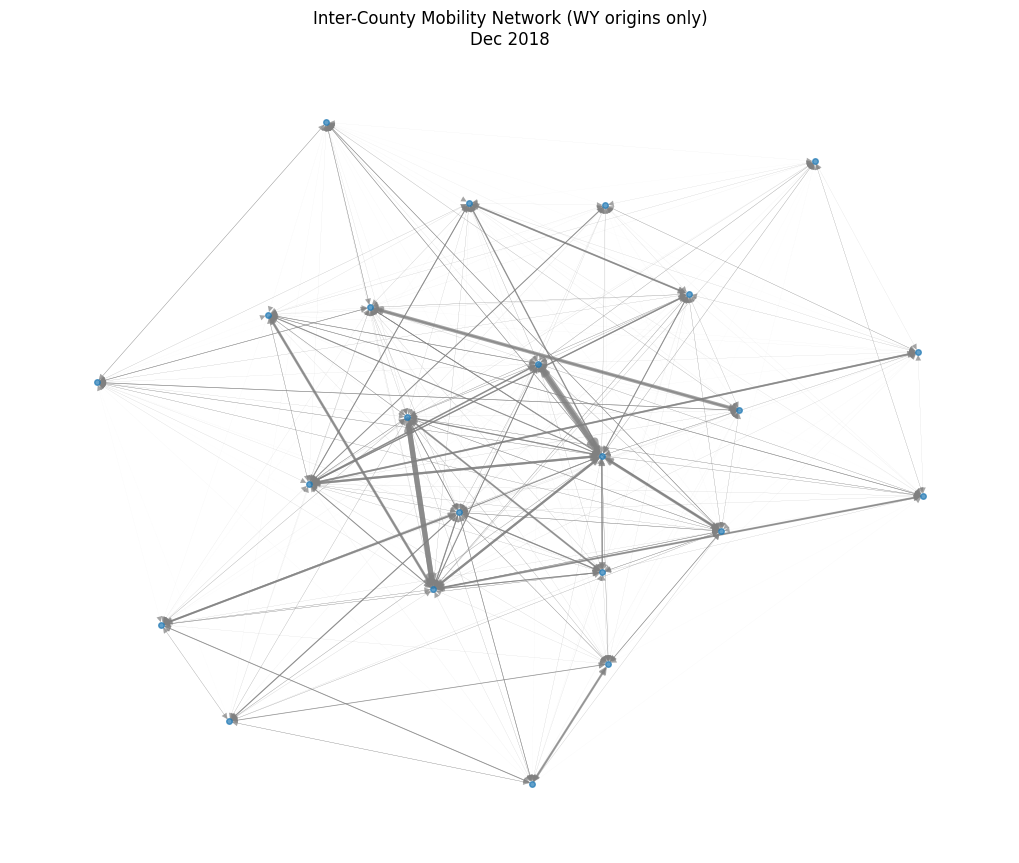

[STATS] Dec 2018 | Avg clustering coeff: 0.9193
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2018_Dec\DegreeDist_Dec_2018.png


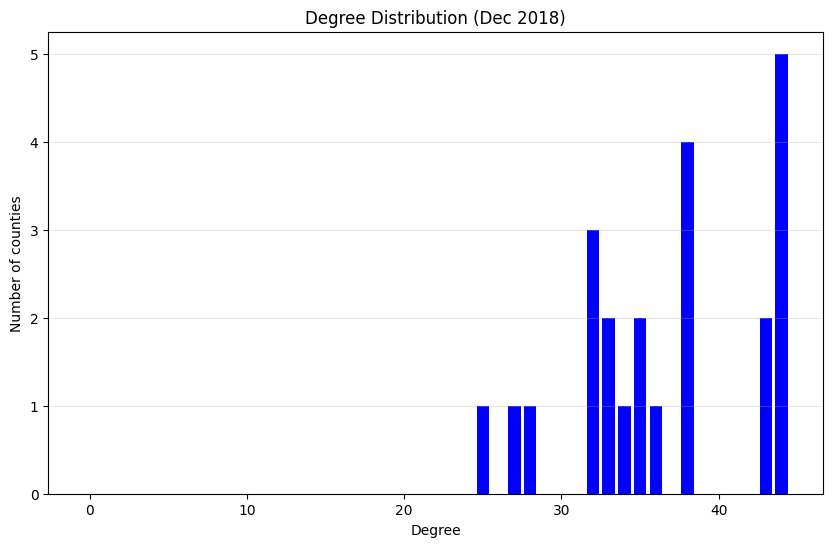


=== Processing July 2019 ===


Expanding July_2019_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 3836.04it/s]


[INFO] July_2019_Only.csv | intra-county links: 23 | inter-county links: 13611
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2019_July\WY_Network_July_2019.png


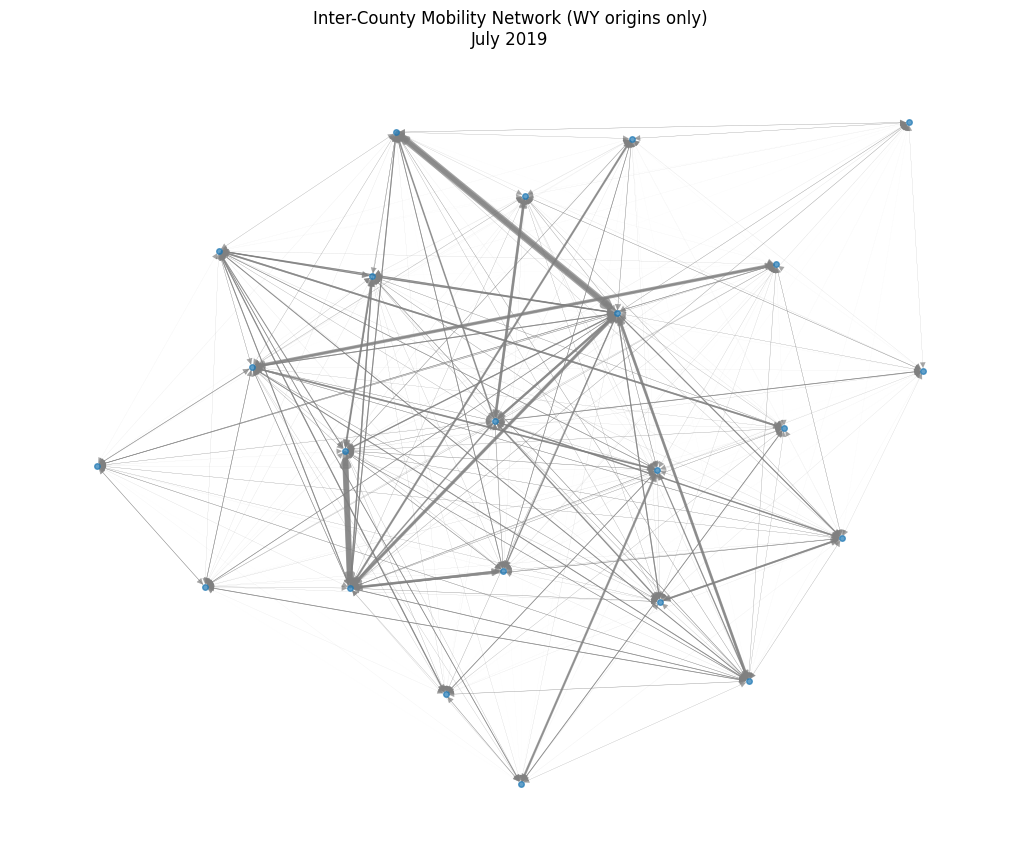

[STATS] July 2019 | Avg clustering coeff: 0.9690
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2019_July\DegreeDist_July_2019.png


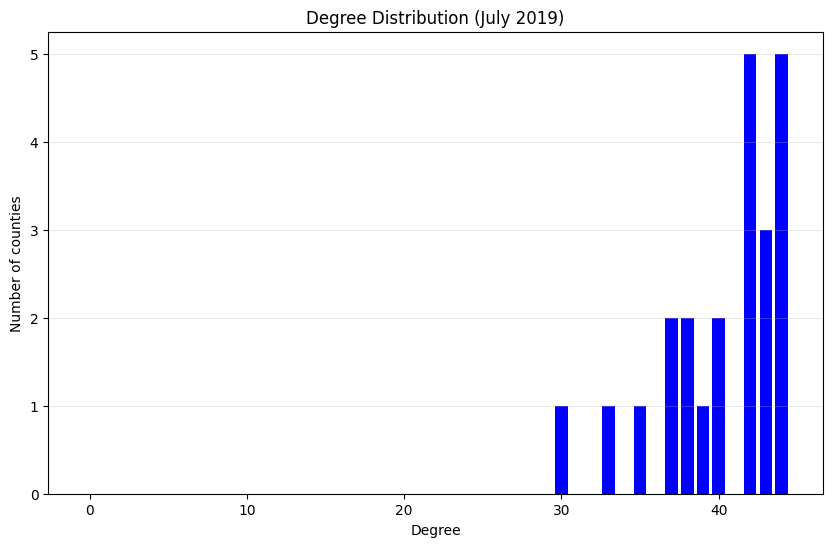


=== Processing Dec 2019 ===


Expanding Dec_2019_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 5469.46it/s]


[INFO] Dec_2019_Only.csv | intra-county links: 23 | inter-county links: 4814
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2019_Dec\WY_Network_Dec_2019.png


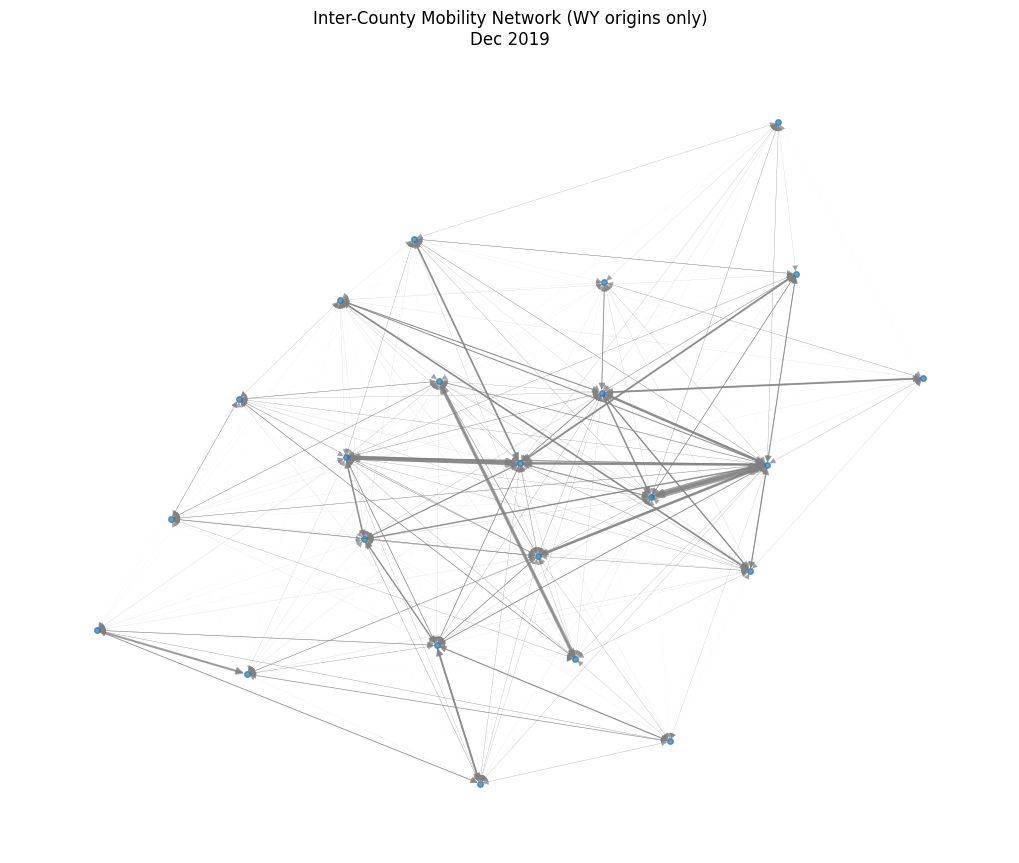

[STATS] Dec 2019 | Avg clustering coeff: 0.9075
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2019_Dec\DegreeDist_Dec_2019.png


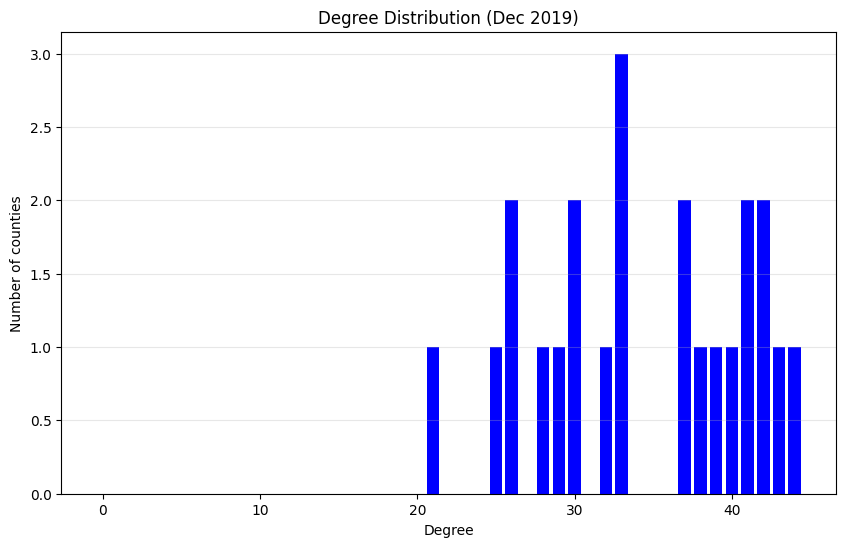


=== Processing July 2020 ===


Expanding July_2020_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 4411.67it/s]


[INFO] July_2020_Only.csv | intra-county links: 23 | inter-county links: 12343
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2020_July\WY_Network_July_2020.png


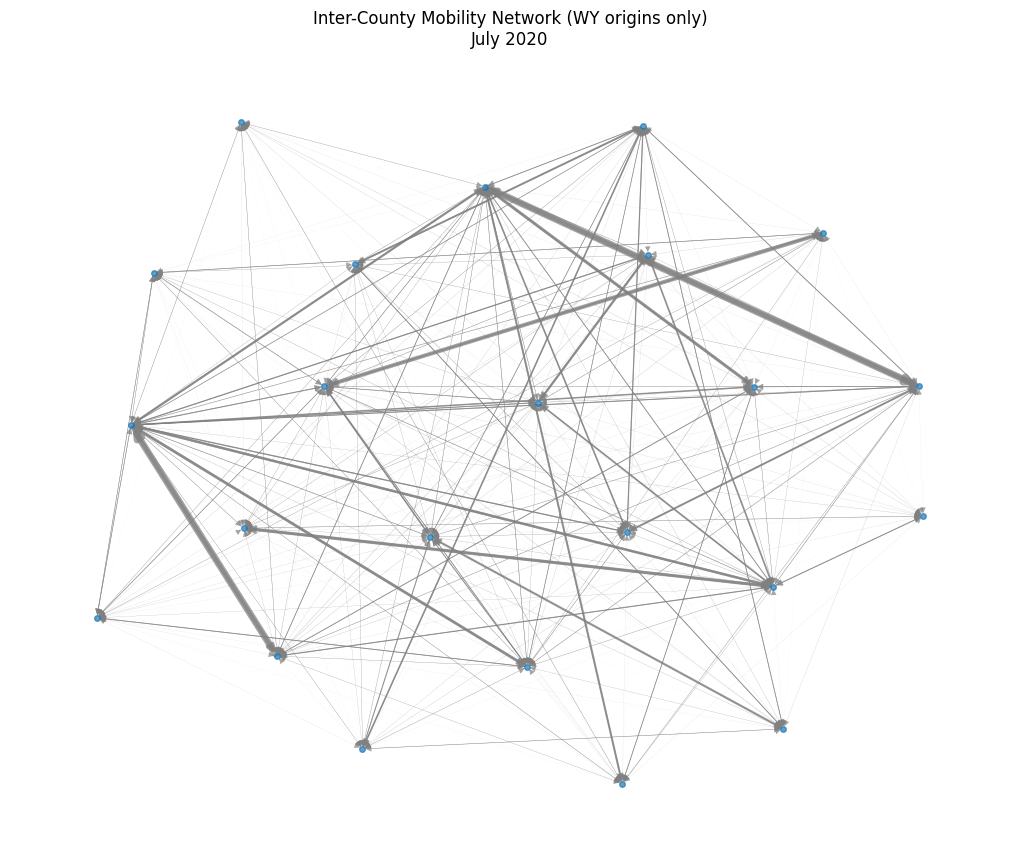

[STATS] July 2020 | Avg clustering coeff: 0.9775
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2020_July\DegreeDist_July_2020.png


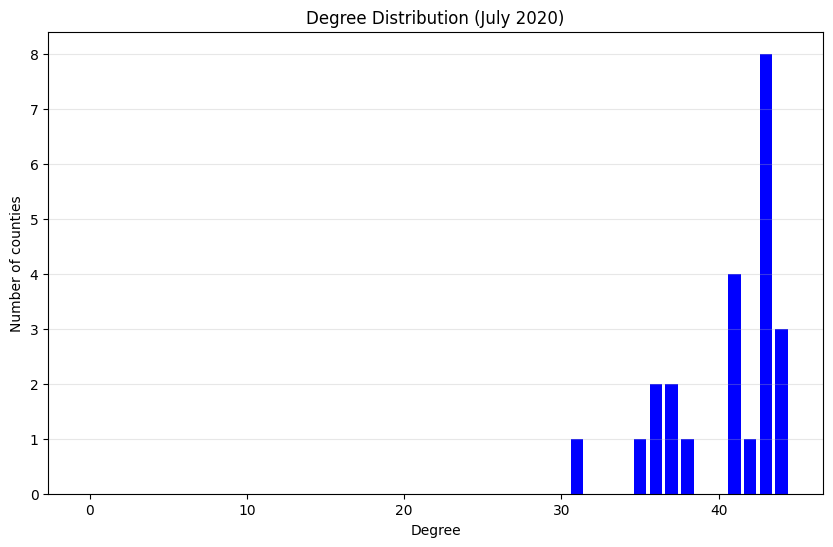


=== Processing Dec 2020 ===


Expanding Dec_2020_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 6307.94it/s]


[INFO] Dec_2020_Only.csv | intra-county links: 23 | inter-county links: 4457
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2020_Dec\WY_Network_Dec_2020.png


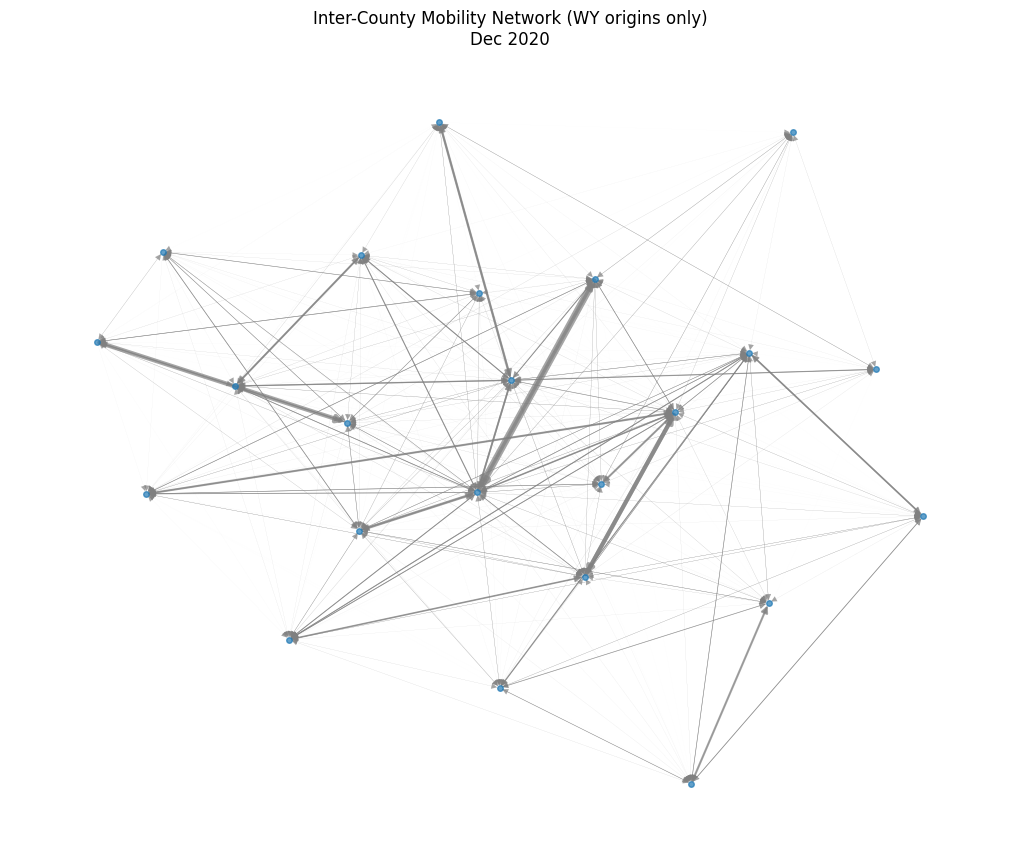

[STATS] Dec 2020 | Avg clustering coeff: 0.8992
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2020_Dec\DegreeDist_Dec_2020.png


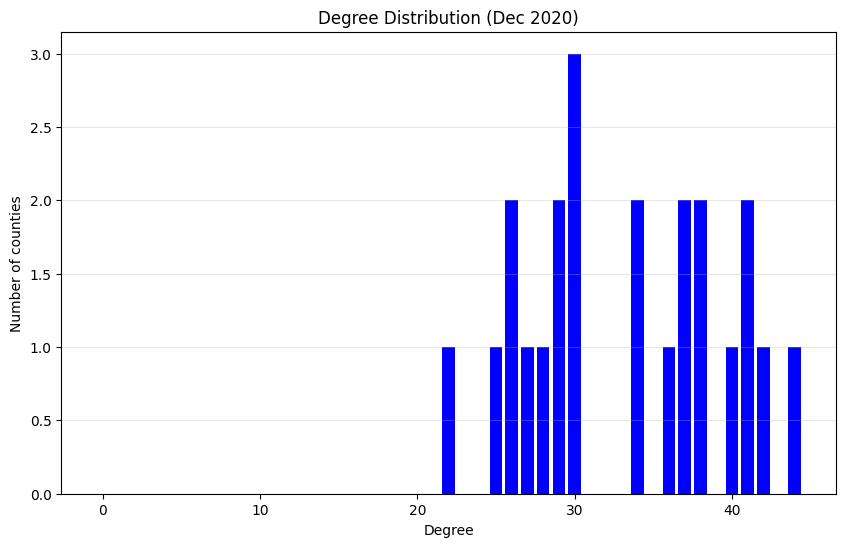


=== Processing July 2021 ===


Expanding July_2021_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 3782.98it/s]


[INFO] July_2021_Only.csv | intra-county links: 23 | inter-county links: 16663
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2021_July\WY_Network_July_2021.png


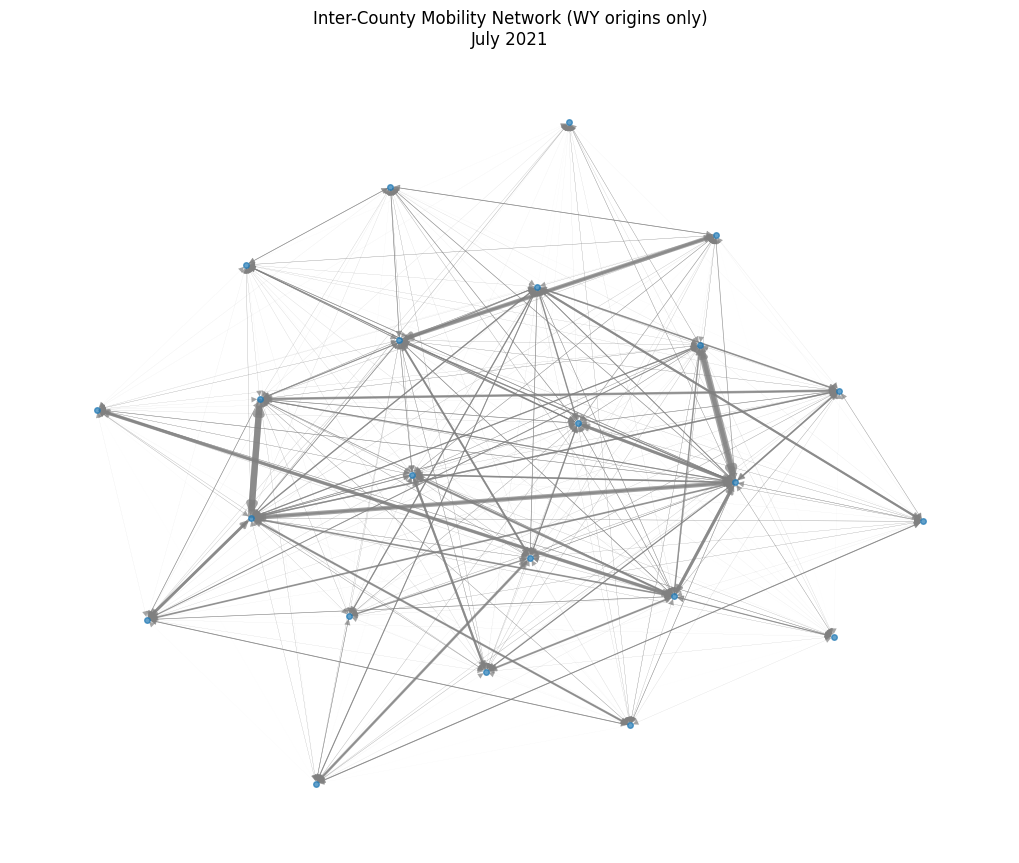

[STATS] July 2021 | Avg clustering coeff: 0.9695
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2021_July\DegreeDist_July_2021.png


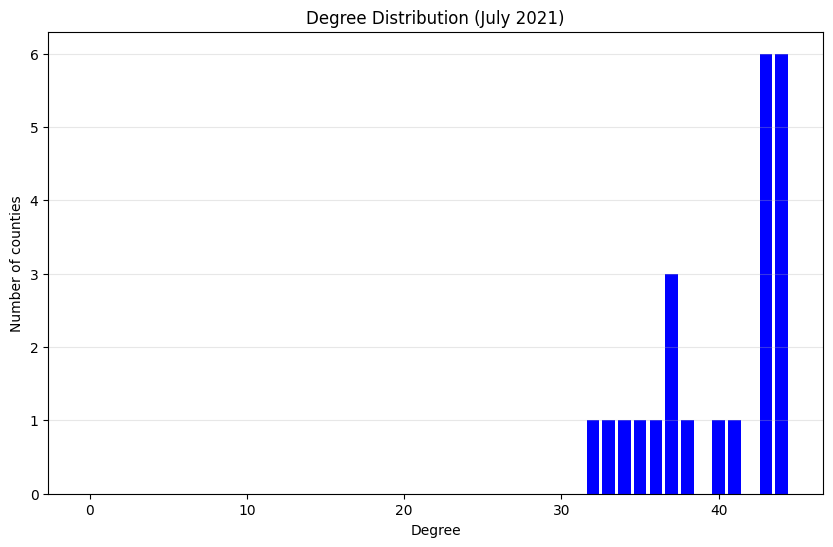


=== Processing Dec 2021 ===


Expanding Dec_2021_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 7052.98it/s]


[INFO] Dec_2021_Only.csv | intra-county links: 23 | inter-county links: 4724
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2021_Dec\WY_Network_Dec_2021.png


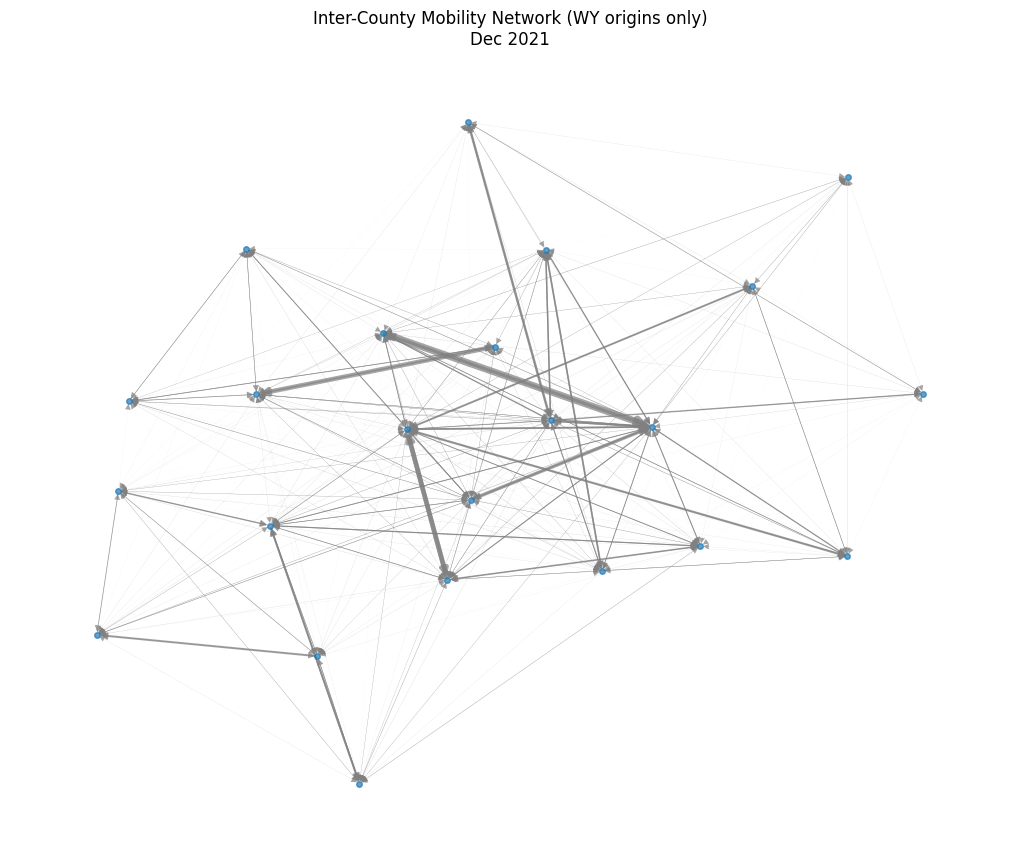

[STATS] Dec 2021 | Avg clustering coeff: 0.8960
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2021_Dec\DegreeDist_Dec_2021.png


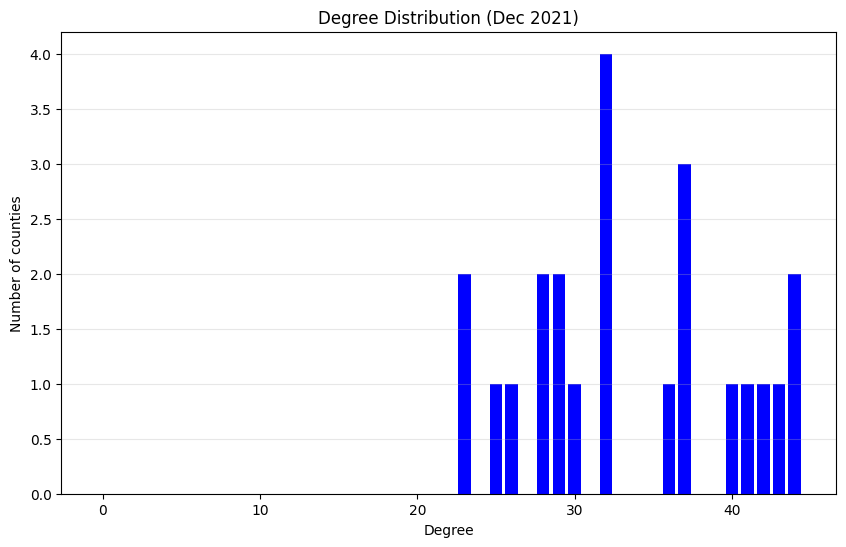


=== Processing July 2022 ===


Expanding July_2022_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 3729.15it/s]


[INFO] July_2022_Only.csv | intra-county links: 23 | inter-county links: 15933
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2022_July\WY_Network_July_2022.png


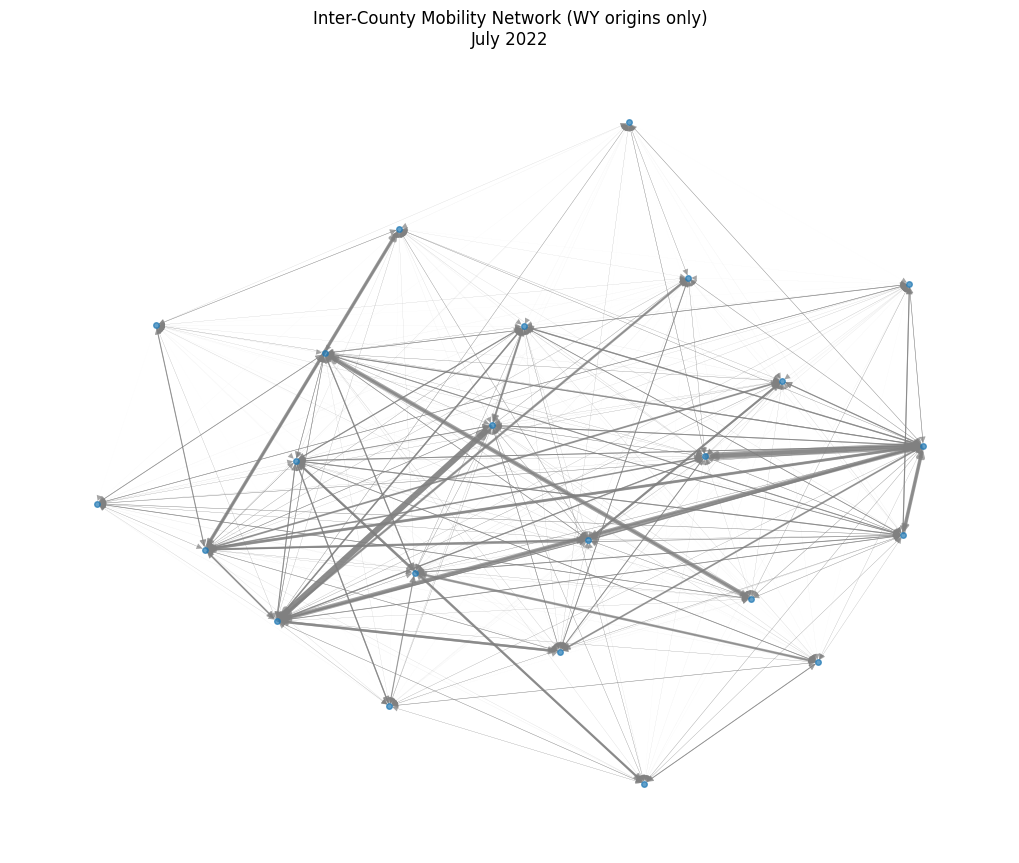

[STATS] July 2022 | Avg clustering coeff: 0.9684
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2022_July\DegreeDist_July_2022.png


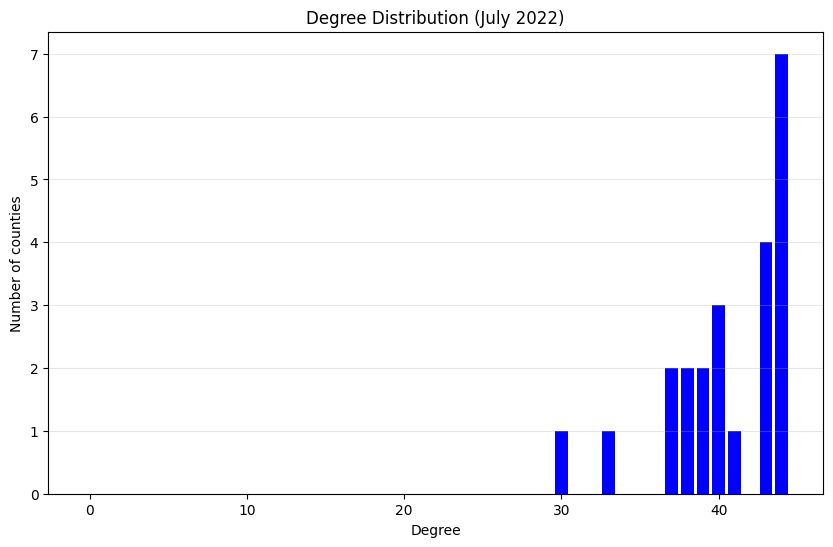


=== Processing Dec 2022 ===


Expanding Dec_2022_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 6122.77it/s]


[INFO] Dec_2022_Only.csv | intra-county links: 23 | inter-county links: 5844
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2022_Dec\WY_Network_Dec_2022.png


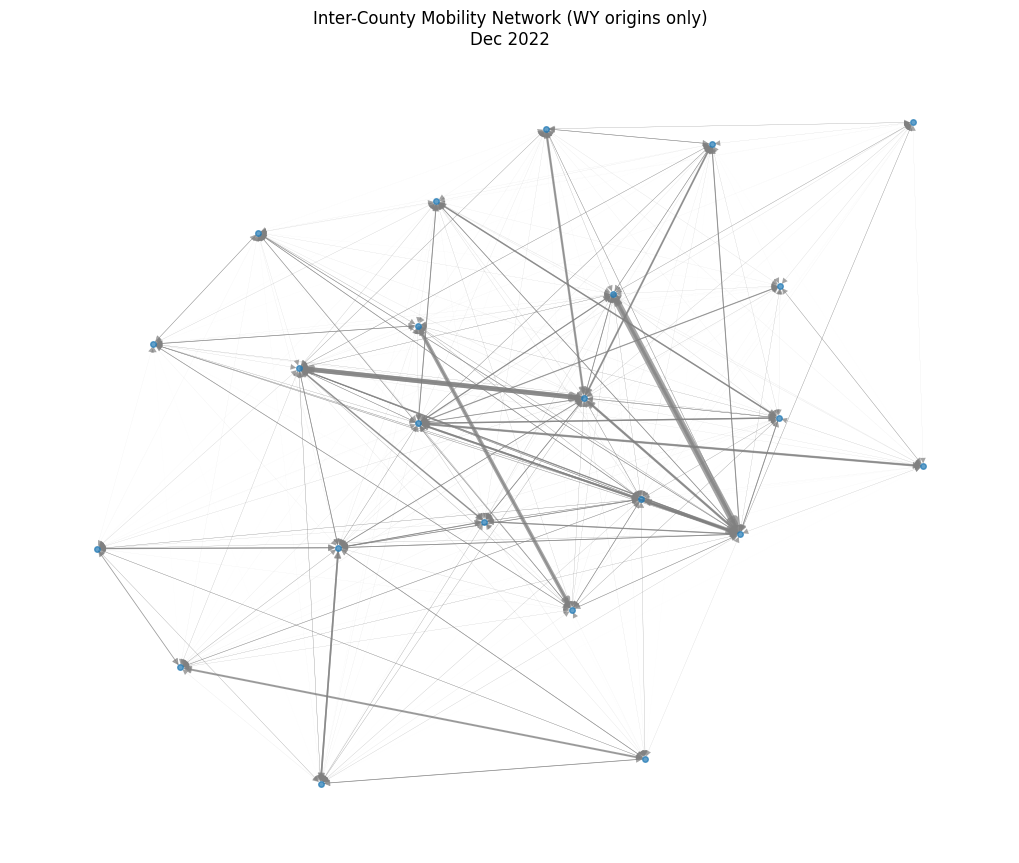

[STATS] Dec 2022 | Avg clustering coeff: 0.9188
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2022_Dec\DegreeDist_Dec_2022.png


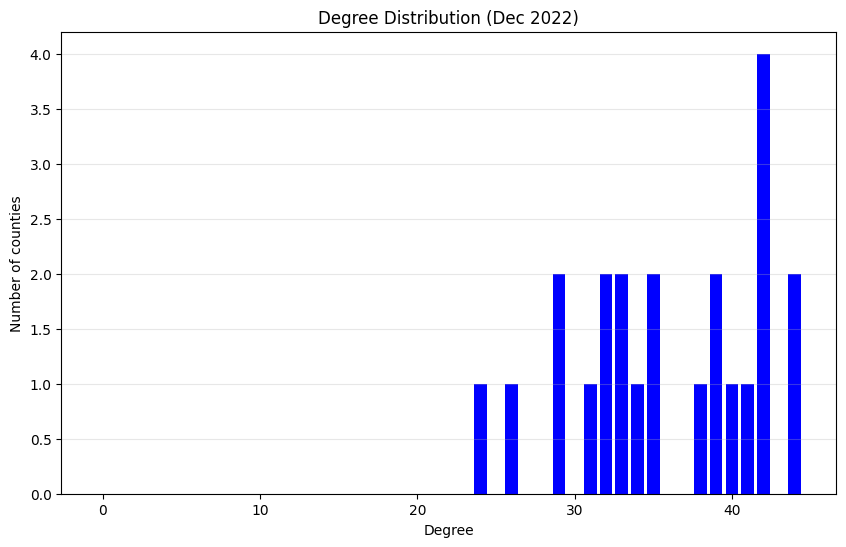


=== Processing July 2023 ===


Expanding July_2023_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 3749.26it/s]


[INFO] July_2023_Only.csv | intra-county links: 23 | inter-county links: 20044
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2023_July\WY_Network_July_2023.png


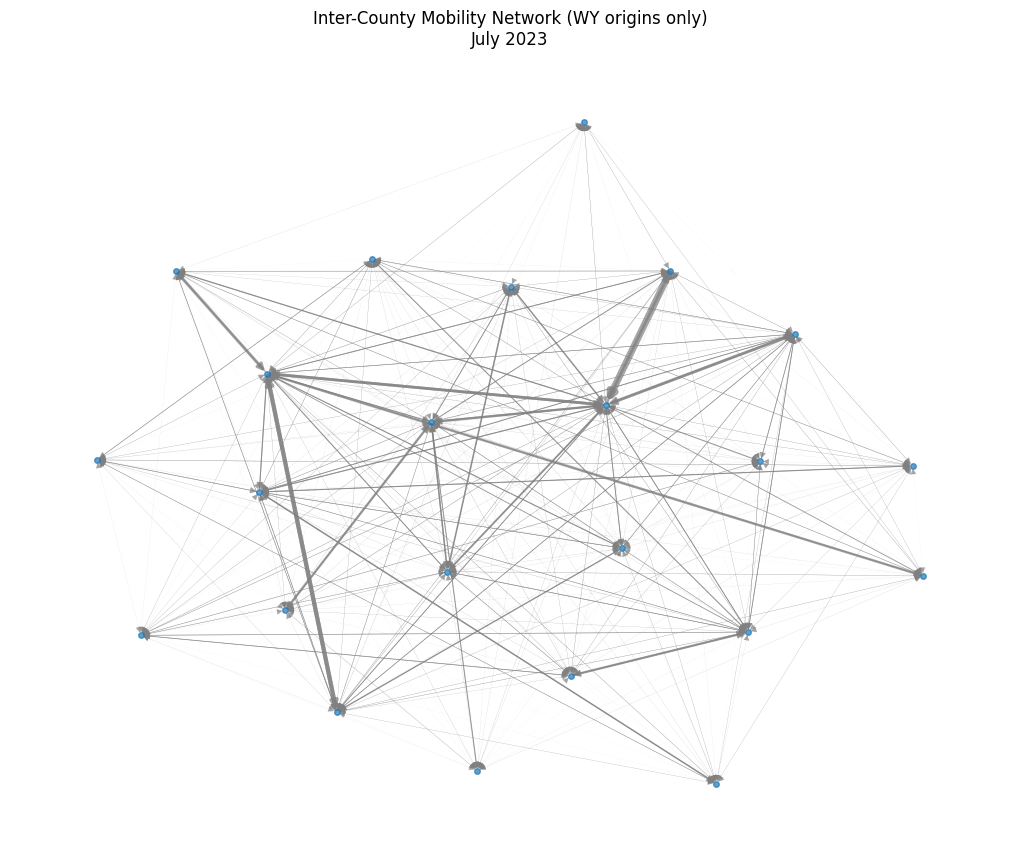

[STATS] July 2023 | Avg clustering coeff: 0.9717
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2023_July\DegreeDist_July_2023.png


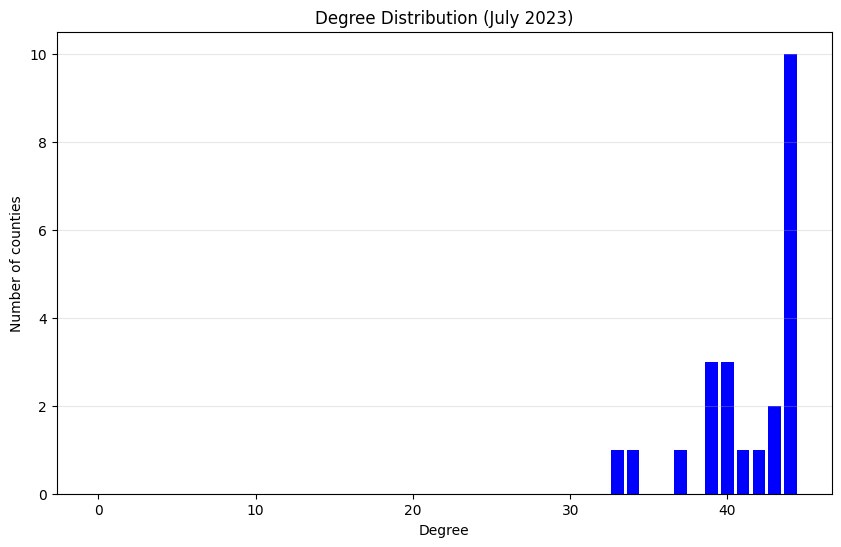


=== Processing Dec 2023 ===


Expanding Dec_2023_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 4523.61it/s]


[INFO] Dec_2023_Only.csv | intra-county links: 23 | inter-county links: 8853
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2023_Dec\WY_Network_Dec_2023.png


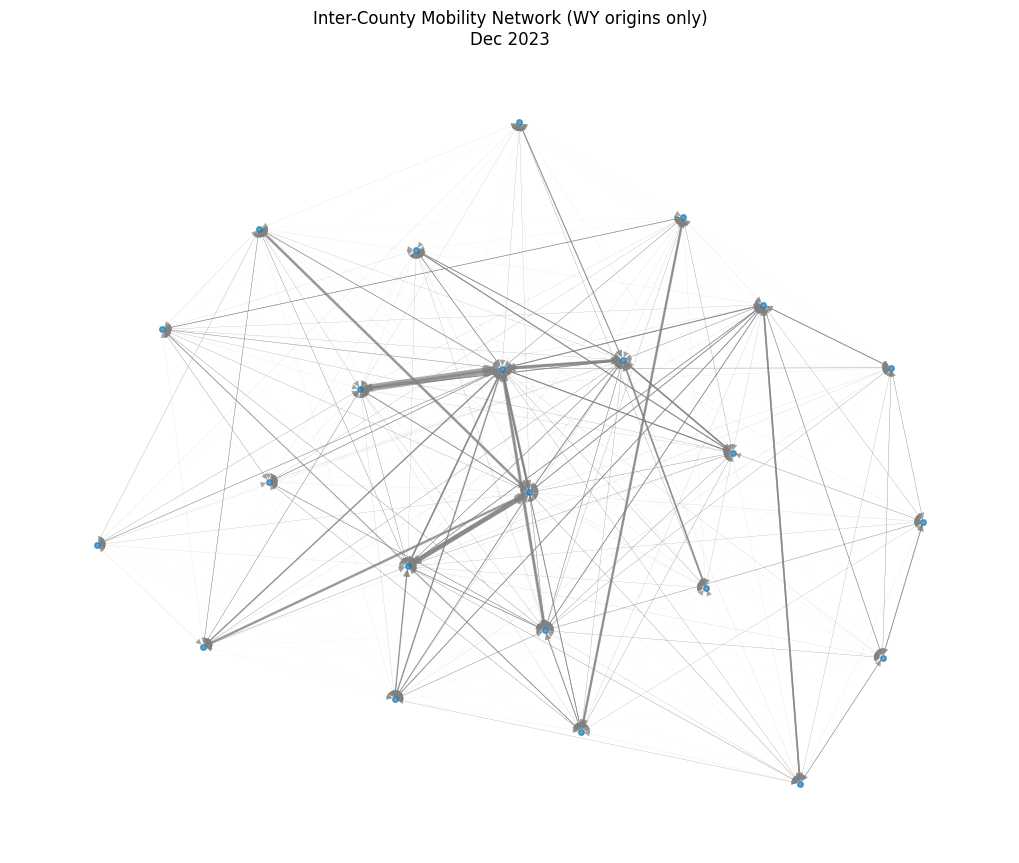

[STATS] Dec 2023 | Avg clustering coeff: 0.9300
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2023_Dec\DegreeDist_Dec_2023.png


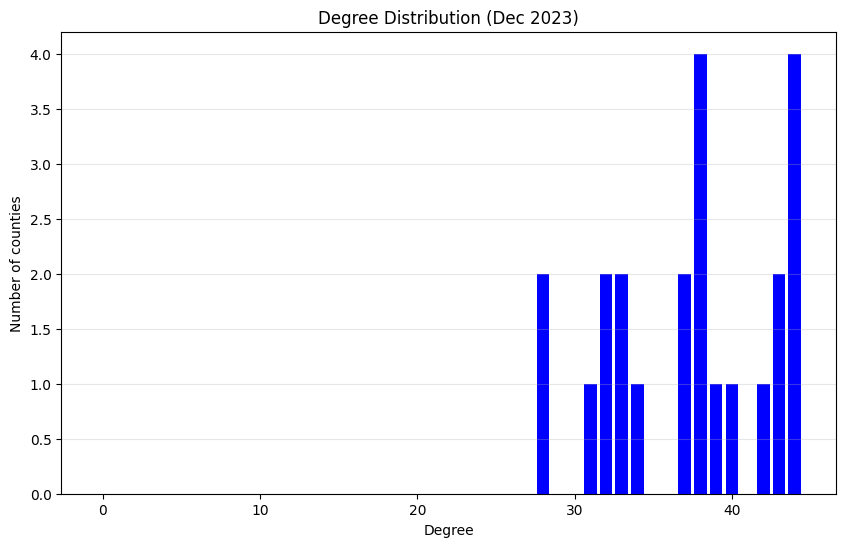


=== Processing July 2024 ===


Expanding July_2024_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 3326.59it/s]


[INFO] July_2024_Only.csv | intra-county links: 23 | inter-county links: 18670
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2024_July\WY_Network_July_2024.png


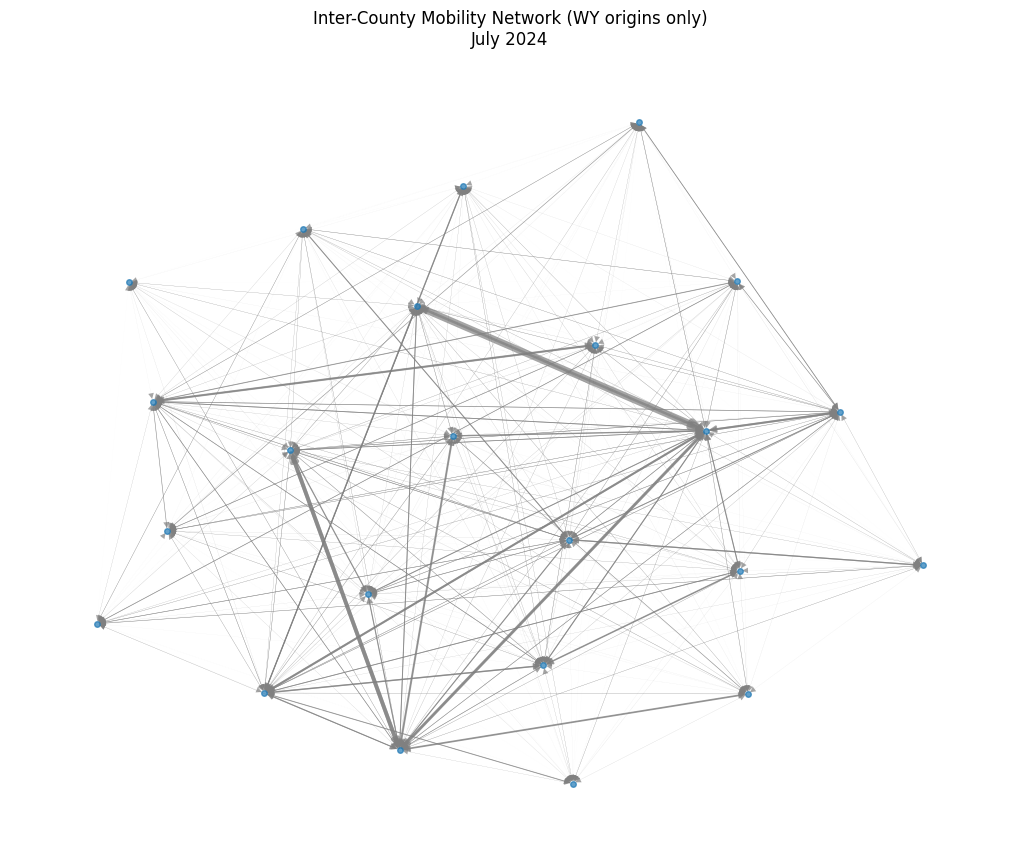

[STATS] July 2024 | Avg clustering coeff: 0.9784
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2024_July\DegreeDist_July_2024.png


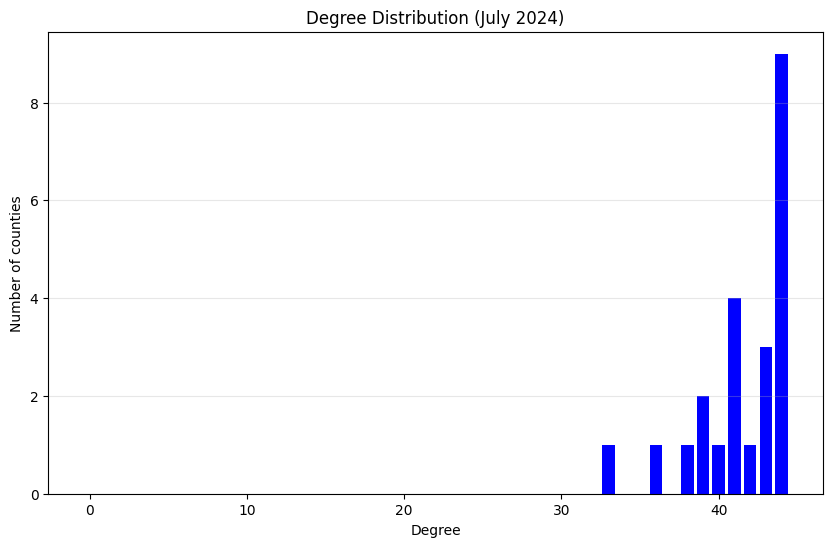


=== Processing Dec 2024 ===


Expanding Dec_2024_Only.csv: 100%|██████████| 410/410 [00:00<00:00, 5663.87it/s]


[INFO] Dec_2024_Only.csv | intra-county links: 23 | inter-county links: 7775
[SAVE] Network plot -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2024_Dec\WY_Network_Dec_2024.png


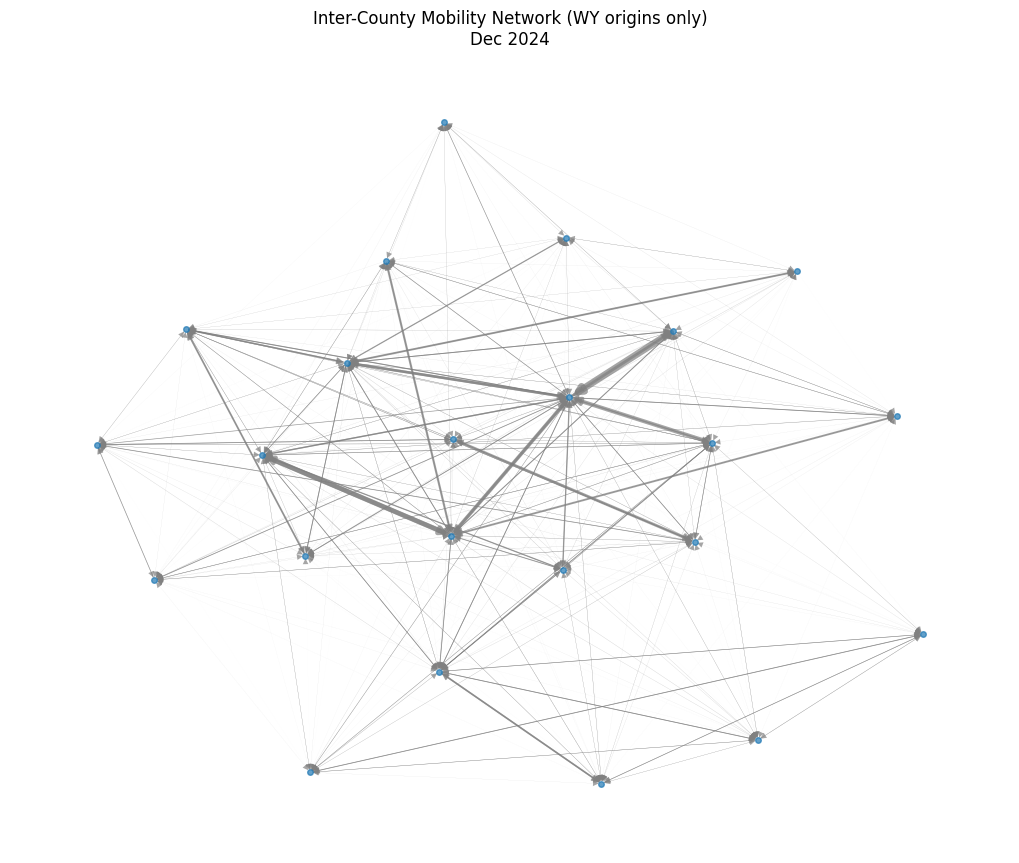

[STATS] Dec 2024 | Avg clustering coeff: 0.9195
[SAVE] Degree distribution -> F:\Yellow Stone Flood-2022\floodanalysis\Plots\Intercounty_Networks\2024_Dec\DegreeDist_Dec_2024.png


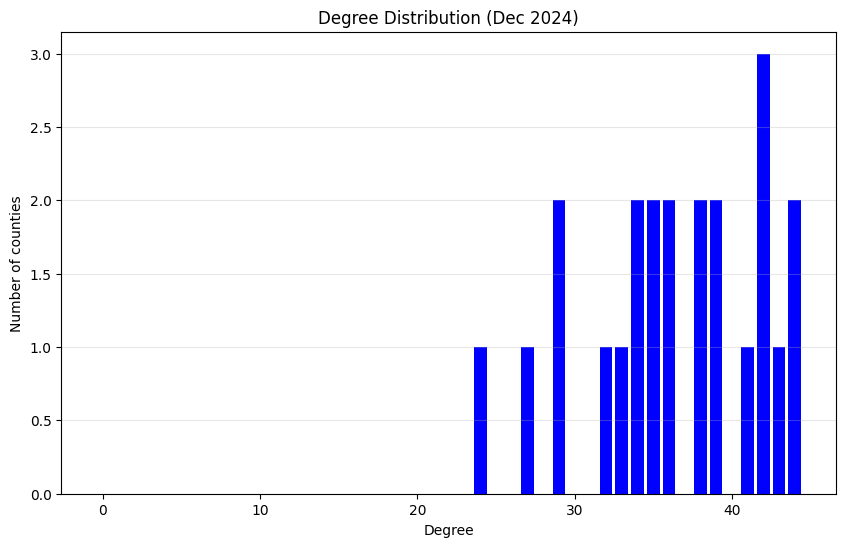


Done.
Snapshots processed:
[(2018, 'July'), (2018, 'Dec'), (2019, 'July'), (2019, 'Dec'), (2020, 'July'), (2020, 'Dec'), (2021, 'July'), (2021, 'Dec'), (2022, 'July'), (2022, 'Dec'), (2023, 'July'), (2023, 'Dec'), (2024, 'July'), (2024, 'Dec')]


In [12]:
all_results = {}

for yr in YEARS:
    for ssn in SEASONS:
        print(f"\n=== Processing {ssn} {yr} ===")
        out = process_snapshot(
            year=yr,
            season=ssn,
            data_dir=DATA_DIR,
            output_base=OUTPUT_BASE,
            show_plots=True   
        )
        if out is not None:
            all_results[(yr, ssn)] = out
        else:
            print(f"[INFO] Skipped {ssn} {yr} (file not found).")

print("\nDone.")
print("Snapshots processed:")
print(list(all_results.keys()))
